In [140]:
import numpy as np
import pandas as pd
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm
import scipy
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import seaborn as sns
%matplotlib inline
#############
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#######################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
#WBC Blood Cell Classification:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

## Visualize One Example the Annotated Picture

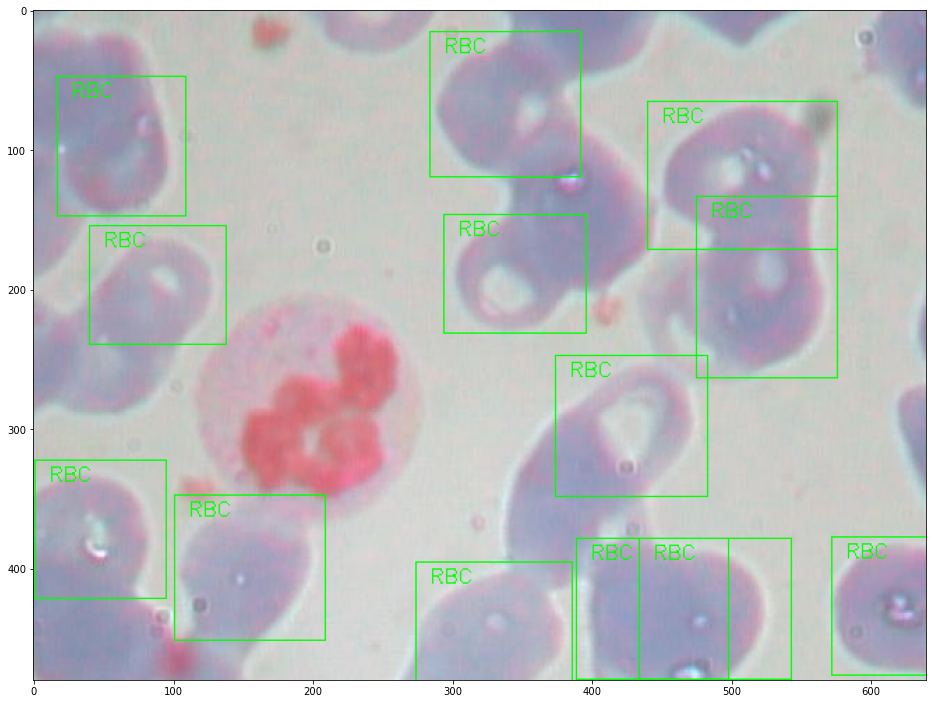

In [34]:
#WBC Blood Cell Classification:
image = cv2.imread("data/dataset-master/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("data/dataset-master/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

# Visualize the random samples of each WBC cell type 

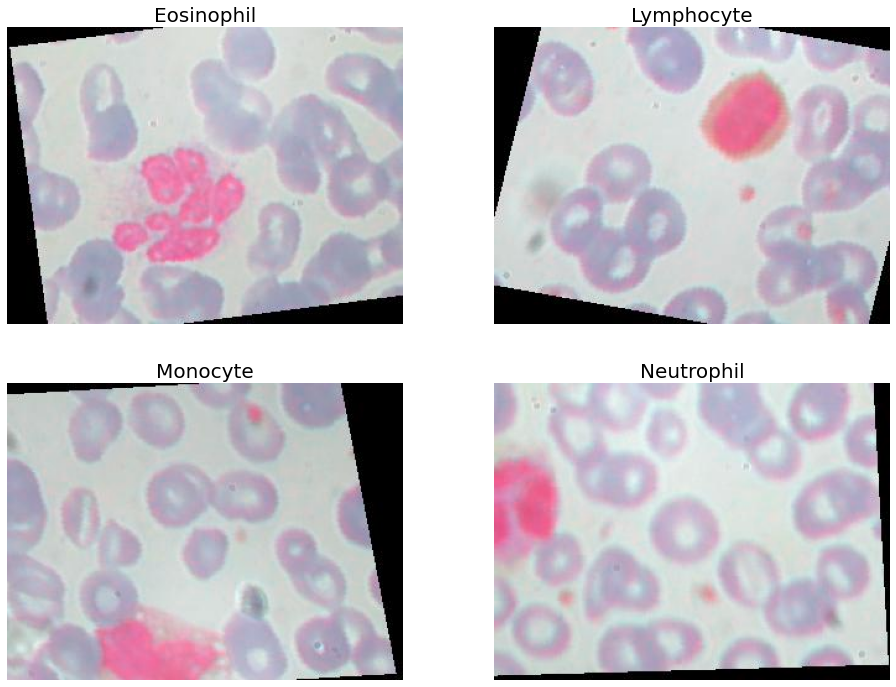

In [35]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.title('Eosinophil',fontsize = 20)
plt.axis('off') 
plotImage(image_name)
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte',fontsize = 20)
plt.axis('off') 
plotImage(image_name)
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte',fontsize = 20)
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil',fontsize = 20)
plt.axis('off') 
plotImage(image_name)

## Original Data is unbalanced among different cell types (classes)

[  3  88  33  21 207]


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Counts')

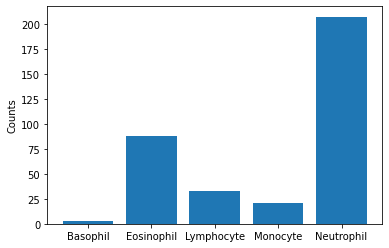

In [36]:
reader = csv.reader(open('data/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

## Augmented data (rotated, zoom-in + zoom-out, random crop, etc.) to make it balanced

In [37]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
#                     img_file = Image.fromarray(img_file).resize(size=(60,80,3))
                    img_file = resize(img_file, (120,160,3)) #reduce the size of the picture
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

X_train, y_train, z_train = get_data('data/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('data/dataset2-master/dataset2-master/images/TEST/')

100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [00:41<00:00, 14.99it/s]


In [138]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

In [139]:
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

C:\Users\parshinshojaee\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


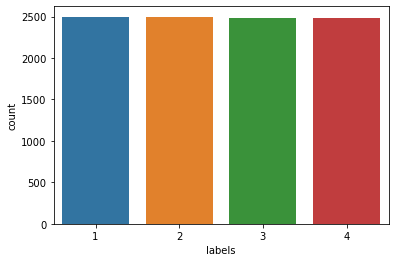

In [38]:
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [156]:
# #Normalize the input images
# X_train *= 255.0/X_train.max()
# X_test *= 255.0/X_test.max()

# # Covert Augmented Data to Torch
# X_train_torch = torch.from_numpy(X_train)
# X_train_torch = X_train_torch.reshape((X_train_torch.shape[0], 3,X_train_torch.shape[1],X_train_torch.shape[2]))
# y_train_torch = torch.from_numpy(y_train-1)
# z_train_torch = torch.from_numpy(z_train)

# X_test_torch = torch.from_numpy(X_test)
# X_test_torch = X_test_torch.reshape((X_test_torch.shape[0],3,X_test_torch.shape[1],X_test_torch.shape[2]))
# y_test_torch = torch.from_numpy(y_test-1)
# z_test_torch = torch.from_numpy(z_test)

# trainset_y = TensorDataset(X_train_torch, y_train_torch)
# trainset_z = TensorDataset(X_train_torch, z_train_torch)
# testset_y = TensorDataset(X_test_torch, y_test_torch)
# testset_z = TensorDataset(X_test_torch, z_test_torch)

# #Torch Data Loader:
# train_minibatch_size = 16
# test_minibatch_size = 512
# train_loader = DataLoader(trainset_y, batch_size = train_minibatch_size, shuffle = True)
# test_loader = DataLoader(testset_y, batch_size = test_minibatch_size, shuffle = True)

In [40]:
class BloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        return self.images[idx], self.labels[idx]

In [41]:
tfms = transforms.Compose([transforms.ToTensor()])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#normalize the input data
mean = tuple((X_train.mean(axis=(0,1,2))/255).round(4))
std = tuple((X_train.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean, std)])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#####################################
tfms = transforms.Compose([transforms.ToTensor()])
test = BloodDataset(X_test, y_test-1, transform=tfms)
mean = tuple((X_test.std(axis=(0,1,2))/255).round(4))
std = tuple((X_test.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean, std)])
test = BloodDataset(X_test, y_test-1, transform=tfms)
##################################
batch_size = 128
test_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=test_size, shuffle=True)

# Task2 : Classification of different cell types

In [42]:
#Train Function:
def train(epoch, model, train_loader):
    model.train()
    
    train_nb_batch = len(train_loader)
    train_loss = 0.0
    train_batch_loss = 0.0
    train_total_loss = 0.0
    train_acc = 0.0
    train_batch_acc = 0.0
    train_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(train_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        #zero that gradients buffer
        optimizer.zero_grad()
        #forward + backward + optimize
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        loss.backward()
        optimizer.step()

        train_batch_loss = loss.item()
        train_total_loss += train_batch_loss
        pred_batch_train = outputs.data.max(1, keepdim=True)[1]
        train_batch_acc = accuracy_score(pred_batch_train,minibatch_y)
        train_total_acc += train_batch_acc
        if i == 0 :
            pred_train = pred_batch_train
        if i >0:
            pred_train = torch.cat([pred_train, pred_batch_train], dim=0) 
    train_loss = train_total_loss/train_nb_batch
    train_acc = train_total_acc/train_nb_batch
    scheduler.step()
    return pred_train, train_loss, train_acc

In [43]:
def test(epoch, model, test_loader):
    model.eval()
    
    test_nb_batch = len(test_loader)
    test_loss = 0.0
    test_batch_loss = 0.0
    test_total_loss = 0.0
    test_acc = 0.0
    test_batch_acc = 0.0
    test_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(test_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        test_batch_loss = loss.item()
        test_total_loss += test_batch_loss
        pred_batch_test = outputs.data.max(1, keepdim=True)[1]
        test_batch_acc = accuracy_score(pred_batch_test,minibatch_y)
        test_total_acc += test_batch_acc
        if i == 0 :
            pred_test = pred_batch_test
        if i >0:
            pred_test = torch.cat([pred_test, pred_batch_test], dim=0)
    test_loss = test_total_loss/test_nb_batch
    test_acc = test_total_acc/test_nb_batch
#     scheduler.step()
    return pred_test, test_loss, test_acc

### Customized Architecture:

In [57]:
#Customized CNN Architecture:
class CNN_Arch2(nn.Module):
    def __init__(self, n_classes):
        super(CNN_Arch2, self).__init__()
        self.conv_layer1 = nn.Sequential(
            #Conv Block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1))
        self.conv_layer2 = nn.Sequential(
            #Conv Block 2
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout(0.3) )
        self.conv_layer3 = nn.Sequential(
            #Conv Block 3
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=5, stride = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout(0.3) )
#         self.conv_layer4 = nn.Sequential(
#             #Conv Block 3
#             nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride = 2),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(4),
#             nn.Dropout(0.1) )
        self.fc_layer1 = nn.Sequential(
            nn.Linear(1020, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2) )
#         self.fc_layer2 = nn.Sequential(
#             nn.Linear(32, 16),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.3) )
#         self.fc_layer3 = nn.Sequential(
#             nn.Linear(16, 8),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.2) )
        self.fc_layer4 = nn.Sequential(
            nn.Linear(32, 4))
#         self.fc_layer5 = nn.Sequential(
#             nn.Linear(4, n_classes))
        
        
    def forward(self, x):
        x = F.pad(x, (0, 0, 1, 2)) # [left, right, top, bot]
        h1 = self.conv_layer1(x)
        h1 = F.pad(h1, (0, 0, 1, 2)) # [left, right, top, bot]
        h2 = self.conv_layer2(h1)
        h2 = F.pad(h2, (0, 0, 1, 2)) # [left, right, top, bot]
        h3 = self.conv_layer3(h2)
#         h3 = F.pad(h3, (0, 0, 1, 2)) # [left, right, top, bot]
#         h4 = self.conv_layer4(h2)
        h4 = h3.view(h3.size(0), -1)
        
        h5 = self.fc_layer1(h4)
#         h6 = self.fc_layer2(h5)
#         h7 = self.fc_layer3(h6)
        h8 = self.fc_layer4(h5)
#         h9 = self.fc_layer5(h8)
        return h8

In [257]:
#  from torchviz import make_dot
# model2 = CNN_Arch2(n_classes)
# x = X_train_torch
# y = model2(x)
# MyConvNetVis = make_dot(y, params=dict(list(MyConvNet.named_parameters()) + [('x', x)]))
# MyConvNetVis.format = "png"
# MyConvNetVis.directory = "data"
# MyConvNetVis.view()

In [58]:
n_classes = 4
model = CNN_Arch2(n_classes)
criterion = nn.CrossEntropyLoss()
lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = MultiStepLR(optimizer, milestones=[5,10,20,40,60,80], gamma=0.5)

In [59]:
num_epoch = 20
train_losses = []
test_losses = []
train_accs = []
test_accs= []

for epoch in range(num_epoch):
    pred_train, train_loss, train_acc = train(epoch, model, train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    pred_test, test_loss, test_acc = test(epoch, model, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print("epoch:",epoch,"train loss:", train_loss, "train accuracy:", train_acc)
    print("epoch:",epoch,"test loss:", test_loss, "test accuracy:", test_acc)

epoch: 0 train loss: 1.3763545155525208 train accuracy: 0.2919760726072607
epoch: 0 test loss: 1.3783497214317322 test accuracy: 0.2753551136363636
epoch: 1 train loss: 1.2149415948452094 train accuracy: 0.4414568259710586
epoch: 1 test loss: 2.670914280414581 test accuracy: 0.2732599431818182
epoch: 2 train loss: 0.9613345311238215 train accuracy: 0.6022745303376491
epoch: 2 test loss: 1.3346660256385803 test accuracy: 0.45111505681818176
epoch: 3 train loss: 0.8067822425793378 train accuracy: 0.6726673568799187
epoch: 3 test loss: 0.9353771448135376 test accuracy: 0.6290767045454546
epoch: 4 train loss: 0.7274717466953473 train accuracy: 0.7010533685580096
epoch: 4 test loss: 1.0716627568006516 test accuracy: 0.5387215909090909
epoch: 5 train loss: 0.6545938497934586 train accuracy: 0.7373649324067022
epoch: 5 test loss: 0.8868808954954147 test accuracy: 0.6233522727272727
epoch: 6 train loss: 0.611652033833357 train accuracy: 0.7572164968900736
epoch: 6 test loss: 0.8166107177734375


KeyboardInterrupt



In [66]:
print('Finished Training')
PATH = './Project_Task2_Arch2_20epoch_lr0001_dropout.pkl'
torch.save(model, PATH)

Finished Training


In [65]:
np.save('train_losses_Arch2_20epoch_dropout.npy', train_losses)
np.save('train_accs_Arch2_20epoch_dropout.npy', train_accs)
np.save('test_losses_Arch2_20epoch_dropout.npy', test_losses)
np.save('test_accs_Arch2_20epoch_dropout.npy', test_accs)

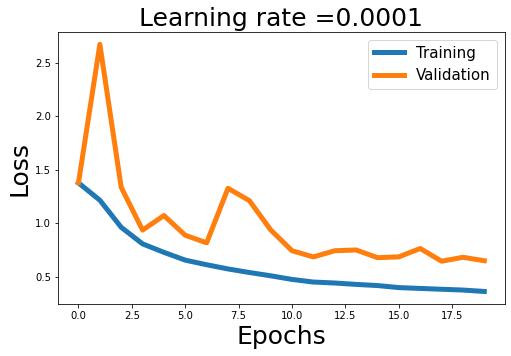

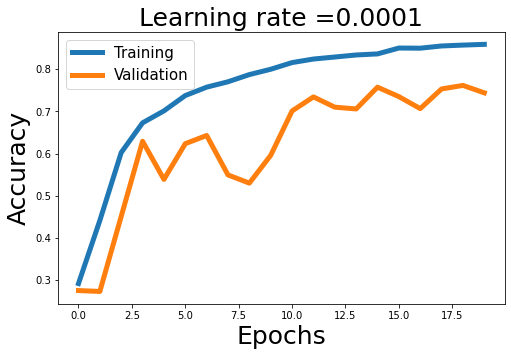

In [68]:
#Plot Train and Validation Loss 
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_losses[:20])),train_losses[:20], label='Training', linewidth=5)
plt.plot(np.arange(len(test_losses[:20])),test_losses[:20], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Loss',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_Arch2_loss.png')
plt.show() 

#Plot Train and Validation Errors
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_accs[:20])),train_accs[:20], label='Training', linewidth=5)
plt.plot(np.arange(len(test_accs[:20])),test_accs[:20], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_Arch2_error.png')
plt.show() 

In [ ]:
# Load Our trained MNIST Model:
PATH = './Project_Task2_Arch2_20epoch_lr0001_dropout.pkl'
model = torch.load(PATH)

# Feature Map

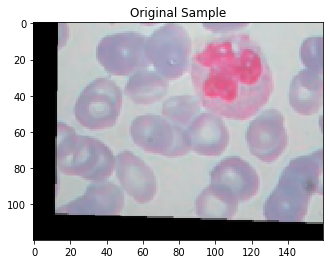

(120, 160, 3)
(3, 120, 160)
torch.Size([1, 3, 120, 160])
(1, 16, 58, 78)


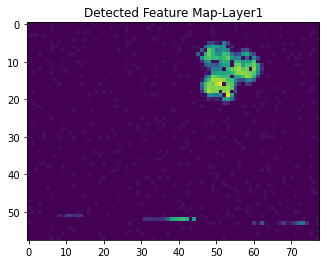

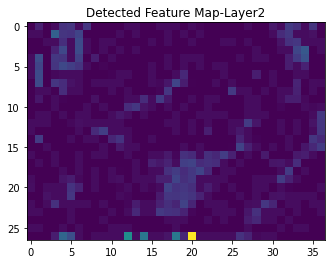

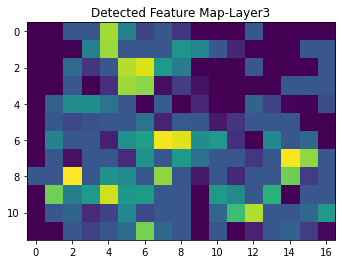

In [115]:
#select a random image sample
n_samples = len(X_test)
random_index = int(np.random.random()*n_samples)
random_sample = X_test[random_index]
plt.imshow(random_sample, interpolation='none')
plt.title("Original Sample")
plt.show()

print(random_sample.shape)
random_sample = np.transpose(random_sample, (2, 0, 1))
print(random_sample.shape)

X_sample = torch.from_numpy(random_sample)
X_sample = X_sample.unsqueeze(0)
print(X_sample.shape)
feature_layer1 = model.conv_layer1(X_sample.float())
feature_layer2 = model.conv_layer2(feature_layer1)
feature_layer3 = model.conv_layer3(feature_layer2)
feature_layer1 = feature_layer1.detach().numpy()
feature_layer2 = feature_layer2.detach().numpy()
feature_layer3 = feature_layer3.detach().numpy()

print(feature_layer1.shape)
plt.imshow(np.transpose(feature_layer1[:,10,:,:], (1, 2, 0)), interpolation='none')
plt.title("Detected Feature Map-Layer1")
plt.show()
plt.imshow(np.transpose(feature_layer2[:,4,:,:], (1, 2, 0)), interpolation='none')
plt.title("Detected Feature Map-Layer2")
plt.show()
plt.imshow(np.transpose(feature_layer3[:,3,:,:], (1, 2, 0)), interpolation='none')
plt.title("Detected Feature Map-Layer3")
plt.show()

# Confusion Matrix

In [122]:
X_test_trans = np.transpose(X_test, (0,3, 1, 2))
X_test_torch = torch.from_numpy(X_test_trans)
y_test_torch = torch.from_numpy(y_test)
predictions = model(X_test_torch.float())
print(X_test_torch.shape, y_test_torch.shape, predictions.shape)

torch.Size([2487, 3, 120, 160]) torch.Size([2487]) torch.Size([2487, 4])


{1, 2, 3, 4}


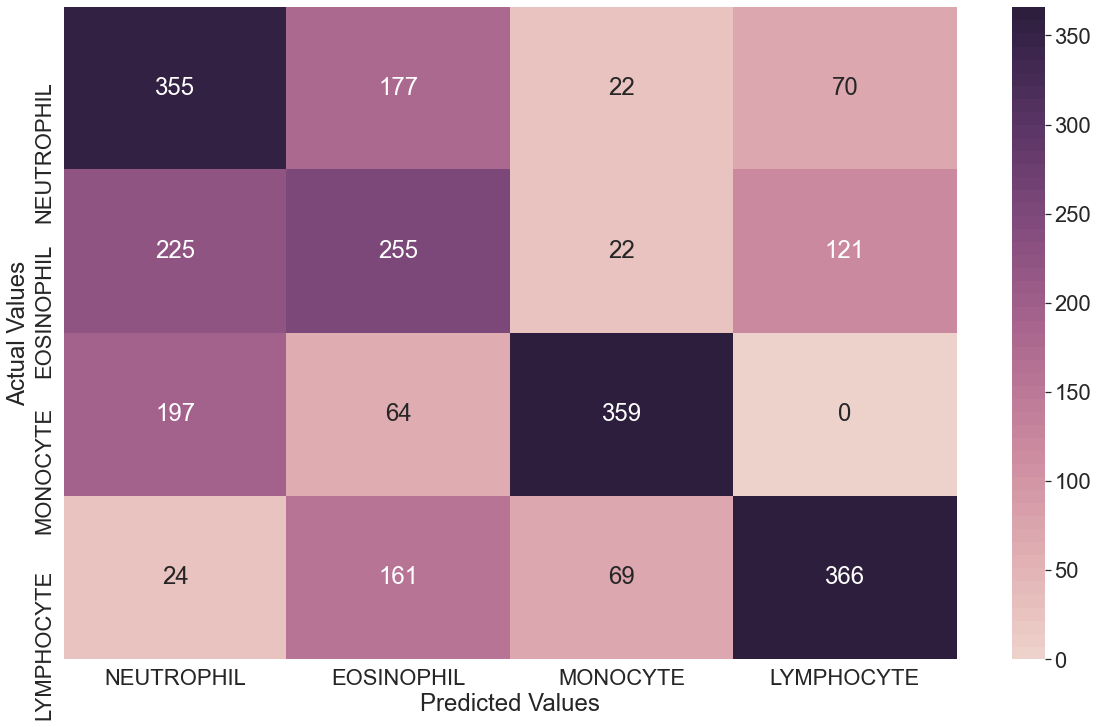

In [137]:
print(set(y_test))
# conf_matrix = confusion_matrix(y_test-1, np.argmax(predictions.detach().numpy(), 1))
conf_matrix = confusion_matrix(y_train-1, np.argmax(predictions_train.detach().numpy(), 1))
confusion_df = pd.DataFrame(conf_matrix)
##########################
dict_characters = {0:'NEUTROPHIL',1:'EOSINOPHIL',2:'MONOCYTE',3:'LYMPHOCYTE'}
#############################
confusion_df = confusion_df.rename(columns=dict_characters)
confusion_df.index = confusion_df.columns
#############################
#Plot Confusion Matrix
plt.figure(figsize= (20,12))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True,fmt='g', cbar = True, cmap=sns.cubehelix_palette(50));
# heatR = sns.heatmap(confusion_df , annot =True , fmt='g', cbar = True, linewidths=2, cmap= 'coolwarm')
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

# Classification Report

In [ ]:
X_train_trans = np.transpose(X_train, (0,3, 1, 2))
X_train_torch = torch.from_numpy(X_train_trans)
predictions_train = model(X_train_torch.float())
print(classification_report(y_train-1, np.argmax(predictions_train.detach().numpy(), 1)))